In [47]:
from sklearn import tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import SVG
from graphviz import Source
from IPython.display import display

from IPython.display import HTML
style = "<style>svg{width: 70% !important; height: 60% !important;} </style>"
HTML(style)

In [3]:
titanic_data = pd.read_csv('D:/Документы/Python/ML/уроки/titanic.csv')

In [4]:
#Задача обучить дерево которое будет предсказывать выживет пасажир или нет основываясь на данных

In [5]:
#Проверить пропущенные значения в данных
titanic_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
#Выявить долю пропущеных значений в данных
titanic_data.isna().sum() / titanic_data.shape[0]

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

In [7]:
#Удалим переменные которые корелируют или объективно не влияют на исход
X = titanic_data.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis = 1)
#axis =1 означает что удаляем колонки с такими именами
y = titanic_data.Survived #переменная которую будем предсказывать

In [8]:
# тк дерево решений не может работать со строковыми данными, нужно еще предобработать данные
X = pd.get_dummies(X) #не трогает числовые значения, а для других создает дополнительные колонки, с 0 и 1
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


In [9]:
# тк дерево решений не может работать с Nan, нужно дополнительно обработать данные, с указанием колонки
# Данный способ, с медианным значением, годиться только для базовой модели, для более точной,
# нужно будет подробнее рассчитать возраст основываясь на других переменных
#X = X.fillna({'Age' : X.Age.median()})

In [10]:
Sex_female = X['Sex_female'].unique().tolist() #список уникальных значений пола
age = []
for i in Sex_female: #расчет медианы возраста для разных значений пола
    a = X.loc[X['Sex_female'] == i]['Age'].median()
    age.append(a)
age_dict = dict(zip(Sex_female, age)) #словарь, где каждому значению пола соответствует медиана возраста
X['Age'] = X['Age'].fillna(X['Sex_female'].map(age_dict)) 

In [11]:
clf = tree.DecisionTreeClassifier(criterion = 'entropy')

In [12]:
clf.fit(X,y) #Обучаем модель

DecisionTreeClassifier(criterion='entropy')

In [13]:
#tree.plot_tree(clf, feature_names=list(X), class_names=['Died', 'Survived'], filled=True)
#plt.show()
#Выводит гиганское дерево, тк рост  не ограничен и дерево пытаясь разделить проводит слишком много сплитов,
# но это еще не значит, что оно неправильное, проверим далее

In [14]:
from sklearn.model_selection import train_test_split #показывать дереву 2 набора данных, то на котором оно обучиться 
# и то на котором протестируется

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [15]:
#clf.fit(X,y) #точность 97%
#clf.fit(X_train,y_train) #точность 97%
#clf.fit(X_test, y_test)
#точность 78% возможно дерево переучено, и вместо того чтобы обобщить и применить на новые данные, дерево занималось тем,что 
# пыталось как можно лучше решить конкретную задачу классификации
# возможная причина, что ресурсы не ограничены

In [16]:
clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth= 3) #max_depth - итерации

In [17]:
clf.fit(X_train,y_train) #84% при 5
clf.score(X_train,y_train)
#clf.fit(X_test, y_test)  #80% при 5 и 82% при 3

0.8238255033557047

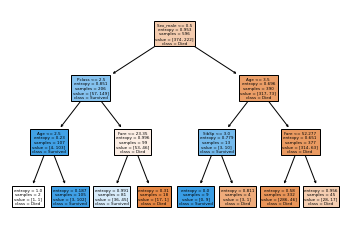

In [18]:
tree.plot_tree(clf, feature_names=list(X), class_names=['Died', 'Survived'], filled=True)
plt.show()

In [19]:
# подберем оптимальноезначение max_depth
max_depth_values = range(1, 100)
scores_data = pd.DataFrame()

In [20]:
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    
    temp_score_data = pd.DataFrame({'max_depth': [max_depth], 'train_score': [train_score], 'test_score': [test_score]})
    
    scores_data = pd.concat([scores_data, temp_score_data])

In [21]:
scores_data.head()

,max_depth,train_score,test_score
0,1,0.781879,0.796610
0,2,0.805369,0.776271
0,3,0.823826,0.820339
0,4,0.833893,0.823729
0,5,0.842282,0.806780


<AxesSubplot:xlabel='max_depth', ylabel='score'>

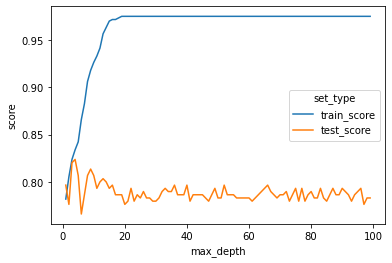

In [22]:
#Нужно преобразовать scores_data так, чтобы для каждой строки были созданы 2 новые: одна со значением точности 
#на тренировочных данных, другая на тестовых. В новом scores_data_long (он long, потому что в нем в два раза больше строк) 
#останется колонка max_depth, которую мы будем использовать как x и появится всего одна колонка score, которую 
#будем использовать как y. Дополнительная третья колонка set_type разделит строки для отрисовки двух линий.
scores_data_long = pd.melt(scores_data, id_vars = ['max_depth'], value_vars = ['train_score','test_score'], \
                           var_name = 'set_type', value_name = 'score')

sns.lineplot(x='max_depth', y='score', hue='set_type', data=scores_data_long)
#синяя линия - c увеличением глубины дерева все лучше классифицируется тот сет данных на котором обучались 
# оранж. линия - впадает в переобучение после ~ 5

In [23]:
#выводы: 
#1.Упрощение модели препятствует переобучению, 
#2.Чем сложнее закономерности в данных, тем более сложная нужна модель для их поиска
#3.Переобученная модель - модель, погрязшая в особенностях тренировочного датасэта, вместо вникания в общие закономерности
#4.Уменьшить переобученность поможет больший объём данных

In [24]:
# Исправить ситуацию поможет  кросс-валидация (перекрестная проверка), разбивающая данные на тренировочную выборку для обучения,
# валидирующее множество для подбора оптимальных параметров и тестовые данные для финального замера точности, так
#train dataset используется для тренировки модели, validation - для её проверки,
#тестовый датасет выступает как ещё один уровень проверки, которая происходит на не показанных модели ранее данных

In [25]:
#Что мы делаем:
#1. Разделяем данные (X_train, y_train) на 5 частей, чтобы одну часть(всегда разную) использовать как тестовые данные, 
# а остальные 4 как тренировочные. Получится, что каждый кусок данных будет использован и в обучении, и в тесте. 
#Для каждой модели усредним accuracy на подвыборках, чтобы потом использовать как единый показатель точности 
# для сравнения разных моделей.
from sklearn.model_selection import cross_val_score
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4)
cross_val_score(clf, X_train, y_train , cv=5) # cv - разбитие, точность array([0.76666667, 0.82352941, 0.79831933, 0.75630252, 0.80672269])


array([0.76666667, 0.82352941, 0.79831933, 0.75630252, 0.80672269])

In [26]:
cross_val_score(clf, X_train, y_train , cv=5).mean() # средняя точность кросс валидации 0.7903081232492998

0.7903081232492998

In [27]:
#Возвращаемся к работе с циклом для поиска оптимальной глубины и добавляем в scores_data среднюю точность на кросс-валидации. 
#(чтобы не было путаницы в одном ноутбуке переименуем  scores_data в cross_val_scores_data)
cross_val_scores_data = pd.DataFrame()
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
   
    mean_cross_val_score = cross_val_score(clf, X_train, y_train , cv=5).mean()
   
    temp_score_data = pd.DataFrame({'max_depth': [max_depth],
                                    'train_score': [train_score],
                                    'test_score': [test_score],
                                    'cross_val_score': [mean_cross_val_score]})
    cross_val_scores_data = pd.concat([cross_val_scores_data, temp_score_data])

In [28]:
cross_val_scores_data.head(20)
#В результате получим датафрейм с колонкой  max_depth и тремя  score

,max_depth,train_score,test_score,cross_val_score
0,1,0.781879,0.796610,0.781961
0,2,0.805369,0.776271,0.770196
0,3,0.823826,0.820339,0.790322
0,4,0.833893,0.823729,0.790308
0,5,0.842282,0.806780,0.795350
0,6,0.865772,0.766102,0.803754
0,7,0.882550,0.786441,0.802059
0,8,0.907718,0.813559,0.800364
0,9,0.917785,0.816949,0.785252
0,10,0.926174,0.803390,0.798683


<AxesSubplot:xlabel='max_depth', ylabel='score'>

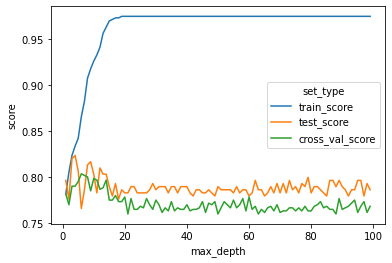

In [29]:
# используя функцию melt, преобразуем данные и построим график:
cross_val_scores_data_long = pd.melt(cross_val_scores_data, id_vars=['max_depth'], \
                                     value_vars=['train_score', 'test_score', 'cross_val_score'],\
                          var_name='set_type', value_name='score')
sns.lineplot(x="max_depth", y="score", hue="set_type", data=cross_val_scores_data_long)


In [30]:
#cross_val_score более устойчив к переобучению, на графике видно, что максимум приходится на глубину до 20. 
#более точное значение максимальной глубины дерева поможет определить

cross_val_scores_data_long.query("set_type == 'cross_val_score'").head(20)

,max_depth,set_type,score
198,1,cross_val_score,0.781961
199,2,cross_val_score,0.770196
200,3,cross_val_score,0.790322
201,4,cross_val_score,0.790308
202,5,cross_val_score,0.795350
203,6,cross_val_score,0.803754
204,7,cross_val_score,0.802059
205,8,cross_val_score,0.800364
206,9,cross_val_score,0.785252
207,10,cross_val_score,0.798683


In [31]:
#Создаем классификатор, указывая лучшее значение аргумента  max_depth. 
#Обучаем на тренировочной выборке и замеряем точность на тестовой.
best_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=11)
best_clf.fit(X_train, y_train)
best_clf.score(X_test, y_test)

0.8

In [32]:
# готовая функция для обучения моделей, позволяет в одном месте собрать "завод" по производству ml
# позволяет взять некоторый estimator(модель) и некоторый набор параметров, который хотим потюнить и комбинацию которых мы хотим 
# попроверять на то, правда ли, что  они лучше всего справляются с поставленной задачей 
# и при помощи cross_validation подобрать такую комбинацию параметров которая дает максимаьно хороший результат
# при этом в качестве результата можно указывать разные метрики
from sklearn.model_selection import GridSearchCV

In [33]:
clf = tree.DecisionTreeClassifier() #пустой, без параметров
parametrs = {'criterion':['gini', 'entropy'], 'max_depth': range(1, 30)}# словарик с параметрами, которые будем тюнить и подбирать их комбинации

In [34]:
grid_search_cv_clf=GridSearchCV(clf, parametrs, cv=5)
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 30)})

In [35]:
grid_search_cv_clf.best_params_ #выбирает лучшие параметры выявленные на кросс валидации

{'criterion': 'entropy', 'max_depth': 6}

In [36]:
best_clf = grid_search_cv_clf.best_estimator_ #сохранено дерево которое имеет глубину 7 и критерий обучения - entropy
best_clf.score(X_test, y_test)

0.7661016949152543

In [37]:
from sklearn.metrics import precision_score, recall_score

In [38]:
y_pred = best_clf.predict(X_test) #предсказанное значение по X_test

In [39]:
precision_score(y_test, y_pred) #y_true это y_test

0.7931034482758621

In [40]:
recall_score(y_test, y_pred)

0.575

<AxesSubplot:>

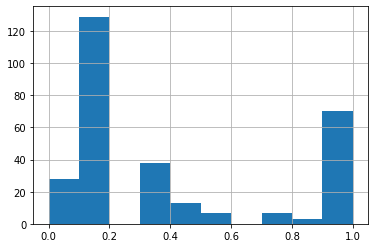

In [41]:
y_predicted_prob = best_clf.predict_proba(X_test) # вероятность предсказания значения по X_test
pd.Series(y_predicted_prob[:,1]).hist() #отберем только вторую колонку и свизуализируем распределения, 
#для возможного сдвига порога с 0.5 на другое число

In [42]:
y_pred = np.where(y_predicted_prob[:,1] >0.8, 1, 0) #перекодирование порога

In [43]:
precision_score(y_test, y_pred) #точность повысилась

0.8493150684931506

In [44]:
recall_score(y_test, y_pred) #высокий  precision и низкий recall

0.5166666666666667

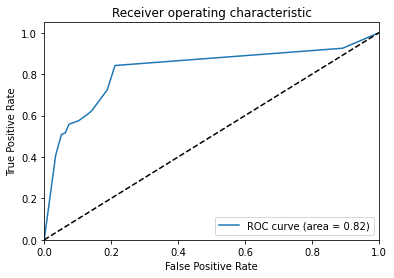

In [45]:
#нужно найти баланс
# рисуем roc кривую, для оценки качества выходных данных классификатора 
# Кривые ROC обычно показывают истинное положительное значение (recall) по оси Y и 
# по оси X ложноположительное значение (обратное, но не precision, а то для какого процента пасажиров дали неправильный ответ) 
from sklearn.metrics import roc_curve, auc


fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1] , 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

#точность ROC кривой 84% - хорошо